# 🔊 Classificação de Áudios do Dataset MIMII 
#### Objetivo: Treinar uma RN para classificar áudios do conjunto pump (-6dB) em normal ou abnormal
##### Framework: PyTorch Lightning
###### Link para download do dataset: https://zenodo.org/records/3384388

In [1]:
# Se faltar pacotes, descomente as linhas abaixo e rode
#!pip install pytorch-lightning torchmetrics librosa soundfile matplotlib scikit-learn tqdm rich

## 🛠️ Imports e configurações

In [2]:
# Imports e configurações
########################################################################
import os
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
import torchmetrics as tm
import librosa
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# Calcular class weights
from sklearn.utils.class_weight import compute_class_weight

# Fixar seed para reprodutibilidade
SEED = 42 # seed fixa para que os resultados sejam sempre os mesmos
seed_everything(SEED, workers=True)

# ===== Caminho do dataset =====
# Altere o caminho:
BASE_PUMP_DIR = r"D:/dataset pump/-6_dB_pump/pump"

# ===== Hiperparâmetros =====
TARGET_SR = 16000      # Taxa de amostragem dos áudios (16 kHz)
N_MELS = 128           # Número de filtros Mel no espectrograma
N_FFT = 1024           # Tamanho da FFT (janela para análise de frequência)
HOP_LENGTH = 512       # Passo entre janelas na STFT
WIN_LENGTH = 1024      # Tamanho da janela de análise
FMIN = 50              # Frequência mínima do espectrograma
FMAX = 8000            # Frequência máxima do espectrograma
CLIP_SECONDS = 10.0    # Duração do áudio após pad/truncamento
TARGET_FRAMES = int(CLIP_SECONDS * TARGET_SR / HOP_LENGTH)  # Nº de frames no espectrograma


BATCH_SIZE = 32     # Quantidade de amostras processadas por vez
LR = 1e-4           # Taxa de aprendizado 
MAX_EPOCHS = 150    # Máximo de épocas de treino
NUM_WORKERS = 0     # Nº de processos para carregar dados (0)

Seed set to 42


## 💻 Listando arquivos e criando rótulos
- Ler todos os IDs (id_00, id_02, id_04, id_06).

- Criar listas X_ALL (caminhos) e Y_ALL (rótulos).

In [3]:
# Listando arquivos e criando rótulos
def list_all_ids(base_pump_dir: str):
    X, y = [], [] # X = caminhos dos arquivos, y = rótulos (0 normal, 1 anormal)
    base = Path(base_pump_dir)
    
    # lista todos os ids (id_00, id_02, etc.)
    for id_dir in sorted(base.glob("id_*")):
        # Lista áudios normais e anormais
        normal_files = sorted(map(str, (id_dir / "normal").glob("*.wav")))
        abnormal_files = sorted(map(str, (id_dir / "abnormal").glob("*.wav")))
        
        # Adiciona caminhos e rótulos correspondentes
        X.extend(normal_files + abnormal_files)
        y.extend([0] * len(normal_files) + [1] * len(abnormal_files))
    
    return X, y

# Executa a função e carrega todos os arquivos com rótulos
X_ALL, Y_ALL = list_all_ids(BASE_PUMP_DIR)

# Informações básicas sobre o dataset
print(f"Total arquivos: {len(X_ALL)}")
print(f"Normais: {Y_ALL.count(0)}, Anormais: {Y_ALL.count(1)}")
print("\nPrimeiros exemplos:")
for i in range(min(5, len(X_ALL))):
    print(Y_ALL[i], X_ALL[i])


# Calcula pesos para balancear as classes
class_weights = compute_class_weight(
    class_weight='balanced',    # Faz o balanceamento automático
    classes=np.unique(Y_ALL),   # Lista das classes (0 e 1)
    y=Y_ALL                     # Lista de rótulos
)

# Converte os pesos para tensor PyTorch
class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("\nPesos das classes:", class_weights)
print(Y_ALL[i], X_ALL[i])

Total arquivos: 4205
Normais: 3749, Anormais: 456

Primeiros exemplos:
0 D:\dataset pump\-6_dB_pump\pump\id_00\normal\00000000.wav
0 D:\dataset pump\-6_dB_pump\pump\id_00\normal\00000001.wav
0 D:\dataset pump\-6_dB_pump\pump\id_00\normal\00000002.wav
0 D:\dataset pump\-6_dB_pump\pump\id_00\normal\00000003.wav
0 D:\dataset pump\-6_dB_pump\pump\id_00\normal\00000004.wav

Pesos das classes: tensor([0.5608, 4.6107])
0 D:\dataset pump\-6_dB_pump\pump\id_00\normal\00000004.wav


## 🎵 Funções para pré-processar áudio

### Carrega o áudio, transforma em mel spectrogram e aplica:

- Conversão para log-mel (dB)

- Pad/trim para ter o mesmo número de frames

- Normalização por amostra (z-score)

Shape final do espectrograma: (128, 312)


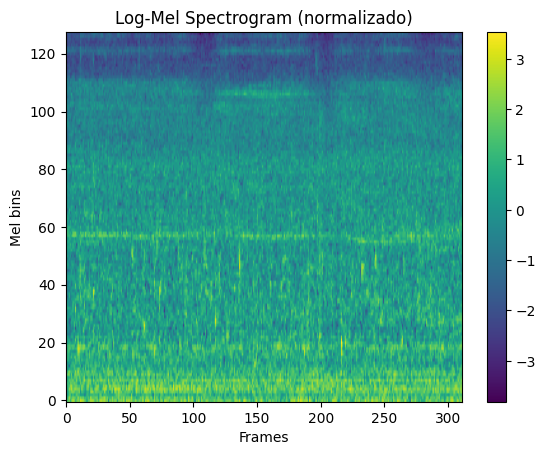

In [4]:
# Funções para pré-processar áudio
def load_audio_mono(path, target_sr=16000):                 # padrão: 16 kHz
    y, sr = librosa.load(path, sr=target_sr, mono=True)     # Retorna apenas o vetor de amostras y, sr é fixo
    return y

def to_logmelspec(y, sr=16000, n_mels=64, n_fft=1024,       
                  hop_length=512, win_length=1024, fmin=50, fmax=8000):
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
    )
    logmel = librosa.power_to_db(mel, ref=np.max)
    return logmel.astype(np.float32)                        # Converte para escala logarítmica (dB) -> próxima a audição humana.

def pad_or_trim(spec, target_frames):  # Garante que todos os espectrogramas tenham o mesmo tamanho em número de frames
    T = spec.shape[1]
    if T == target_frames:
        return spec
    elif T > target_frames:
        return spec[:, :target_frames]
    else:
        pad_T = target_frames - T
        return np.pad(spec, ((0,0),(0,pad_T)), mode="constant")

def instance_norm(spec, eps=1e-6):  # Função para normalizar
    mean = spec.mean()
    std = spec.std()
    if std < eps:
        return spec * 0.0
    return (spec - mean) / std

# Testando com um arquivo para exemplo
if len(X_ALL) > 0:
    y = load_audio_mono(X_ALL[0], TARGET_SR)
    spec = to_logmelspec(y, sr=TARGET_SR, n_mels=N_MELS, n_fft=N_FFT,
                         hop_length=HOP_LENGTH, win_length=WIN_LENGTH,
                         fmin=FMIN, fmax=FMAX)
    spec = pad_or_trim(spec, TARGET_FRAMES)
    spec = instance_norm(spec)

    print("Shape final do espectrograma:", spec.shape)
    plt.imshow(spec, aspect="auto", origin="lower")
    plt.title("Log-Mel Spectrogram (normalizado)")
    plt.xlabel("Frames")
    plt.ylabel("Mel bins")
    plt.colorbar()
    plt.show()

## 📝 Dataset e DataModule

- Divide o conjunto em treino/val/teste.

- Cria DataLoaders para alimentar o modelo.

##### Obs.: Mostra quantos arquivos ficaram em cada split.

In [5]:
class MIMIIDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files      # Guarda a lista de caminhos dos arquivos
        self.labels = labels    # Guarda a lista dos respectivos rótulos

    def __len__(self):
        return len(self.files)  # Diz quantos exemplos existem no dataset.

    def __getitem__(self, idx): # Pega um exemplo específico pelo índice
        path = self.files[idx]
        label = self.labels[idx] 

        # Carregar e pré-processar áudio
        y = load_audio_mono(path, TARGET_SR) # Carrega e resampleia para 16kHz
        spec = to_logmelspec(                # Converte para log-mel spectrogram
            y, sr=TARGET_SR, n_mels=N_MELS, n_fft=N_FFT,
            hop_length=HOP_LENGTH, win_length=WIN_LENGTH,
            fmin=FMIN, fmax=FMAX
        )
        spec = pad_or_trim(spec, TARGET_FRAMES) # Garante tamanho fixo
        spec = instance_norm(spec)              # Normaliza

        # Converter para tensor: (1, N_MELS, T)
        x = torch.from_numpy(spec).unsqueeze(0)     # Espectrograma → tensor PyTorch no formato (1, N_MELS, T)
        y_t = torch.tensor(label, dtype=torch.long) # rótulo como inteiro
        return x, y_t

# Organiza e fornece os dados para treino, validação e teste de forma automática no Lightning
class MIMIIDataModule(pl.LightningDataModule):      
    def __init__(self, X, y, batch_size=32, num_workers=0):
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Divisão: 70% treino, 15% validação, 15% teste 
        X_train, X_temp, y_train, y_temp = train_test_split(
            self.X, self.y, test_size=0.3, random_state=SEED, stratify=self.y # Mantém proporção de normais/anormais para cada parte.
        )
        X_val, X_test, y_val, y_test = train_test_split(
            X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp
        )
        # Cria os datasets (PyTorch) prontos para cada conjunto.
        self.train_ds = MIMIIDataset(X_train, y_train)
        self.val_ds = MIMIIDataset(X_val, y_val)
        self.test_ds = MIMIIDataset(X_test, y_test)

        print(f"Tamanho train: {len(self.train_ds)}, val: {len(self.val_ds)}, test: {len(self.test_ds)}")

    def train_dataloader(self):
        # Oversampling para balancear classes
        class_counts = np.bincount([y for _, y in zip(self.X, self.y)])
        weights = 1. / class_counts
        sample_weights = [weights[label] for label in self.train_ds.labels]
        sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))
        return DataLoader(
            self.train_ds,
            batch_size=self.batch_size,
            sampler=sampler,
            num_workers=self.num_workers,
            pin_memory=True)

    def val_dataloader(self): 
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False,
                          num_workers=self.num_workers, pin_memory=True)


# Instancia o DataModule com todos os arquivos e rótulos
datamodule = MIMIIDataModule(X_ALL, Y_ALL, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
datamodule.setup()


Tamanho train: 2943, val: 631, test: 631


## 🧠 Modelo CNN simples

#### Essa CNN vai usar o espectrograma log-mel (1 × N_MELS × T) e processar com:

- Camadas convolucionais para extrair padrões de tempo/frequência

- Pooling para reduzir tamanho e aumentar invariância

- Global Average Pooling para reduzir para um vetor fixo

- Camada Linear final para 2 classes (normal / abnormal)

In [6]:
class DeeperCNN(nn.Module):
    def __init__(self, n_mels, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(256),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        return self.classifier(self.features(x))


## ⚡ LightningModule

- Forward (passagem para frente no modelo)

- Loss (CrossEntropy)

- Métricas (Accuracy e AUROC usando torchmetrics)

- Otimização (Adam + scheduler opcional)

- Passos de treino, validação e teste

In [7]:
class LitAudioClassifier(LightningModule):                  # forma do Lightning de organizar o ciclo de treinamento
    def __init__(self, lr=LR, class_weights=None):          # lr e pesos para balancear as classes no cálculo da perda
        super().__init__()
        self.save_hyperparameters(ignore=["class_weights"])
        self.model = DeeperCNN(n_mels=N_MELS, n_classes=2)  # recebe a rede 

        # Se passar class_weights, registra como buffer para ir junto pro device
        if class_weights is not None:
            self.register_buffer("class_weights", class_weights)  
        else:
            self.class_weights = None

        self.loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)  # penaliza mais erros na classe minoritária

        # Métricas
        self.train_acc = tm.classification.MulticlassAccuracy(num_classes=2)
        self.val_acc = tm.classification.MulticlassAccuracy(num_classes=2)
        self.val_auc = tm.classification.MulticlassAUROC(num_classes=2)
        self.test_acc = tm.classification.MulticlassAccuracy(num_classes=2)
        self.test_auc = tm.classification.MulticlassAUROC(num_classes=2)

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr) # Adam para ajustar os pesos da rede durante o treino
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)                                # Calcula logits
        loss = self.loss_fn(logits, y)                  # Aplica a função de perda
        preds = torch.argmax(logits, dim=1)             # Obtém previsões (argmax)
        self.train_acc.update(preds, y)                 # Atualiza métrica de acurácia
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    # Calcula a acurácia média da época
    def on_train_epoch_end(self):
        self.log("train_acc", self.train_acc.compute(), prog_bar=True)
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.val_acc.update(preds, y)
        probs = torch.softmax(logits, dim=1)
        self.val_auc.update(probs, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    # Calcula e loga métricas da validação
    def on_validation_epoch_end(self):
        self.log("val_acc", self.val_acc.compute(), prog_bar=True)
        self.log("val_auc", self.val_auc.compute(), prog_bar=True)
        self.val_acc.reset()
        self.val_auc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        probs = torch.softmax(logits, dim=1)
        self.test_auc.update(probs, y)
        self.log("test_loss", loss)
        return loss

    def on_test_epoch_end(self):
        self.log("test_acc", self.test_acc.compute())
        self.log("test_auc", self.test_auc.compute())
        self.test_acc.reset()
        self.test_auc.reset()


## 🚀 Treinamento da rede

In [8]:
# Callbacks
# Salva o melhor modelo com base na métrica de validação (val_loss)
checkpoint_cb = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    filename="mimii-pump-6db-{epoch:02d}-{val_loss:.4f}"    # nome do arquivo salvo
)
# Interrompe o treino cedo se não houver melhora na val_loss
earlystop_cb = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5
)
# Monitora a taxa de aprendizado a cada época 
lr_monitor = LearningRateMonitor(logging_interval="epoch")

# Modelo
model = LitAudioClassifier(lr=LR, class_weights=class_weights)

# Trainer
trainer = Trainer(
    max_epochs=MAX_EPOCHS,
    deterministic=True,  # garante reprodutibilidade
    callbacks=[checkpoint_cb, earlystop_cb, lr_monitor],
    accelerator="auto",  # usa GPU se disponível
    devices="auto",
    log_every_n_steps=10
)

# Início do treinamento 
trainer.fit(model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | DeeperCNN          | 569 K  | train
1 | loss_fn   | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | val_auc   | MulticlassAUROC    | 0      | train
5 | test_acc  | MulticlassAccuracy | 0      | train
6 | test_auc  | MulticlassAUROC    | 0      | train
---------------------------------------------------------
569 K     Trainable params
0         Non-trainable params
569 K     Total params
2.279     Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


Tamanho train: 2943, val: 631, test: 631


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\steva\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\steva\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\steva\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## ✅ Avaliação no conjunto de teste
- avalia o melhor modelo salvo e gera as métricas no conjunto de teste.

Melhor checkpoint salvo: d:\dataset pump\lightning_logs\version_10\checkpoints\mimii-pump-6db-epoch=20-val_loss=0.1492.ckpt
Tamanho train: 2943, val: 631, test: 631


c:\Users\steva\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\steva\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9042680859565735     │
│         test_auc          │    0.9569010734558105     │
│         test_loss         │    0.29112300276756287    │
└───────────────────────────┴───────────────────────────┘


Resultados no conjunto de teste:
[{'test_loss': 0.29112300276756287, 'test_acc': 0.9042680859565735, 'test_auc': 0.9569010734558105}]

Matriz de confusão:
[[538  25]
 [ 10  58]]

Relatório de classificação:
              precision    recall  f1-score   support

           0     0.9818    0.9556    0.9685       563
           1     0.6988    0.8529    0.7682        68

    accuracy                         0.9445       631
   macro avg     0.8403    0.9043    0.8684       631
weighted avg     0.9513    0.9445    0.9469       631



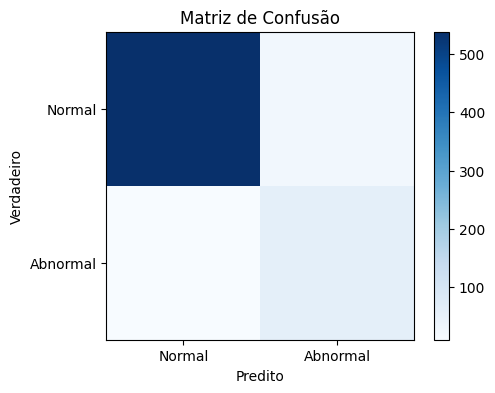

In [9]:
# Carregar melhor modelo salvo
best_ckpt = checkpoint_cb.best_model_path
print(f"Melhor checkpoint salvo: {best_ckpt}")

best_model = LitAudioClassifier.load_from_checkpoint(
    best_ckpt,
    class_weights=class_weights
)

# Avaliação no conjunto de teste
test_results = trainer.test(best_model, datamodule=datamodule)
print("\nResultados no conjunto de teste:")
print(test_results)

# Predições no conjunto de teste para gerar matriz de confusão
y_true = []
y_pred = []

best_model.eval()
for x, y in datamodule.test_dataloader():
    with torch.no_grad():
        logits = best_model(x)
        preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()
    y_pred.extend(preds)
    y_true.extend(y.cpu().numpy().tolist())

# Métricas detalhadas
print("\nMatriz de confusão:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

print("\nRelatório de classificação:")
print(classification_report(y_true, y_pred, digits=4))

# Plot da matriz de confusão
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Matriz de Confusão")
plt.colorbar()
plt.xticks([0,1], ["Normal", "Abnormal"])
plt.yticks([0,1], ["Normal", "Abnormal"])
plt.xlabel("Predito")
plt.ylabel("Verdadeiro")
plt.show()